In [101]:
import pandas as pd
import numpy as np
from sklearn import neighbors, datasets, preprocessing
from matplotlib import pyplot as plt
% matplotlib inline

In [102]:
# function applies SMOTE algorithm to input dataframe using k-neighbours
# inputs: dataframe - pd.DataFrame, last column should comtain labels
#         k - number of neighbors for the algorithm
def smote(dataframe, k, random_state=0):
    # get the labels of input dataframe
    np.random.seed(random_state)
    labels = dataframe.iloc[:, -1]
    # extract unique labels and count number of examples for each one
    unq_labels, cnt_labels = np.unique(labels, return_counts=True)
    # detect minor class and major class
    unq_labels = list(unq_labels)
    cnt_labels = list(cnt_labels)
    imbalanced_label = unq_labels.index(cnt_labels.index(min(cnt_labels)))
    max_label = unq_labels.index(cnt_labels.index(max(cnt_labels)))
    # calculate for how many times minor class should be extended to reach major one
    num_imbalanced = min(cnt_labels)
    num_max_label = max(cnt_labels)
    increase_rate = int(num_max_label / num_imbalanced) - 1
    synth_data = []
    
    # rescale Dataframe values
    columns = dataframe.columns
    labels = np.array(dataframe.iloc[:, -1])
    scaler = preprocessing.MinMaxScaler()
    data = dataframe.iloc[:, :-1]
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    dataframe = pd.DataFrame(scaled_data)
    dataframe['label'] = labels
    
    # extract minor class examples
    imbalanced_class = dataframe.loc[dataframe.iloc[:, -1] == 0]
    
    for i in range(num_imbalanced):
        # fit nearest neighbors, number is k + 1 to find k neighbors apart from duplicate which is always the first
        neigh = neighbors.NearestNeighbors(n_neighbors=k + 1)
        neigh.fit(dataframe.iloc[:, :-1], dataframe.iloc[:, -1])
        # find indices of kneighbors in input dataset
        ind_array = neigh.kneighbors(X=[imbalanced_class.iloc[i, :-1]],return_distance=False)
        # generate synthetic datapoints for minor class i-th example
        new_data = populate(dataframe, imbalanced_class, increase_rate, i, ind_array, random_state)
        for j in range(len(new_data)):
            synth_data.append(new_data[j])   
    # process synthetic datapoints and merge with initial dataset        
    synth_data = np.array(synth_data)
    synth_data_dataframe = pd.DataFrame(synth_data)
    synth_data_dataframe.columns = dataframe.iloc[:, :-1].columns
    synth_labels = [imbalanced_label for i in range(synth_data_dataframe.shape[0])]
    synth_data_dataframe['label'] = synth_labels
    new_dataframe = pd.concat([dataframe, synth_data_dataframe])
    
    # inverse scaling 
    labels = np.array(new_dataframe.iloc[:, -1])
    new_data = new_dataframe.iloc[:, :-1]
    scaled_new_data = scaler.inverse_transform(new_data)
    new_dataframe = pd.DataFrame(scaled_new_data)
    new_dataframe['label'] = labels
    new_dataframe.columns = columns
    return new_dataframe
 
# function generates synthetic datapoints using a datapoint and its nearest neighbors indices
# inputs: dataframe - initial imbalanced dataframe
#         imbalanced_class - dataframe containing only minor class
#         inc_rate - hom many times minor class should be extended
#         i - index of minor class example
#         ind_array - array containing nearest neighbors indices in initital imbalanced dataframe 
def populate(dataframe, imbalanced_class, inc_rate, i, ind_array, random_state):
    # list for new synthetic data
    np.random.seed(random_state)
    synth_data = []
    while inc_rate != 0:
        # choose random neighbour from 1 to k, ignore 0 because it is duplicate
        rand_k = int(np.random.random() * len(list(ind_array - 1))) + 1
        # list for attributes of one datapoint
        new_datapoint = []
        for attr in range(dataframe.iloc[:, :-1].shape[1]):
            # calculate distance between neighbour and input minor class datapoint
            dist = float(dataframe.iloc[ind_array[:, rand_k], attr]) - float(imbalanced_class.iloc[i, attr])
            gap = np.random.random()
            # add attribute for synthetic datapoint
            new_datapoint.append(imbalanced_class.iloc[i, attr] + gap * dist)
        # append datapoint to the list with synthetic datapoints    
        synth_data.append(new_datapoint)
        inc_rate -= 1
    return synth_data     

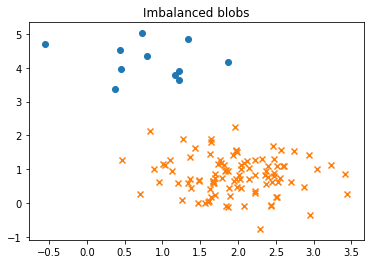

In [103]:
blobs = pd.read_csv('./imbalanced_datasets/imbalanced_blobs.csv')
label_0 = blobs.loc[blobs['label'] == 0]
label_1 = blobs.loc[blobs['label'] == 1]
plt.title('Imbalanced blobs')
plt.scatter(label_0.x1, label_0.x2, marker='o')
plt.scatter(label_1.x1, label_1.x2, marker='x')
plt.show()

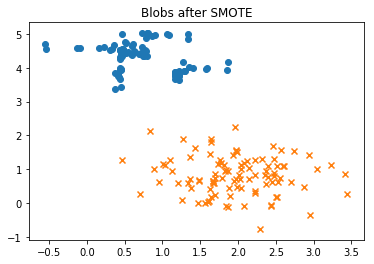

In [104]:
new_blobs = smote(blobs, 3)
label_0 = new_blobs.loc[new_blobs['label'] == 0]
label_1 = new_blobs.loc[new_blobs['label'] == 1]
plt.title('Blobs after SMOTE')
plt.scatter(label_0.x1, label_0.x2, marker='o')
plt.scatter(label_1.x1, label_1.x2, marker='x')
# plt.show()

In [105]:
print 'Number of class 0 after SMOTE:', new_blobs.loc[new_blobs['label'] == 0].shape[0]
print 'Number of class 1 after SMOTE:', new_blobs.loc[new_blobs['label'] == 1].shape[0]

Number of class 0 after SMOTE: 99
Number of class 1 after SMOTE: 100


In [106]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df['label'] = iris.target

In [107]:
import seaborn as sns

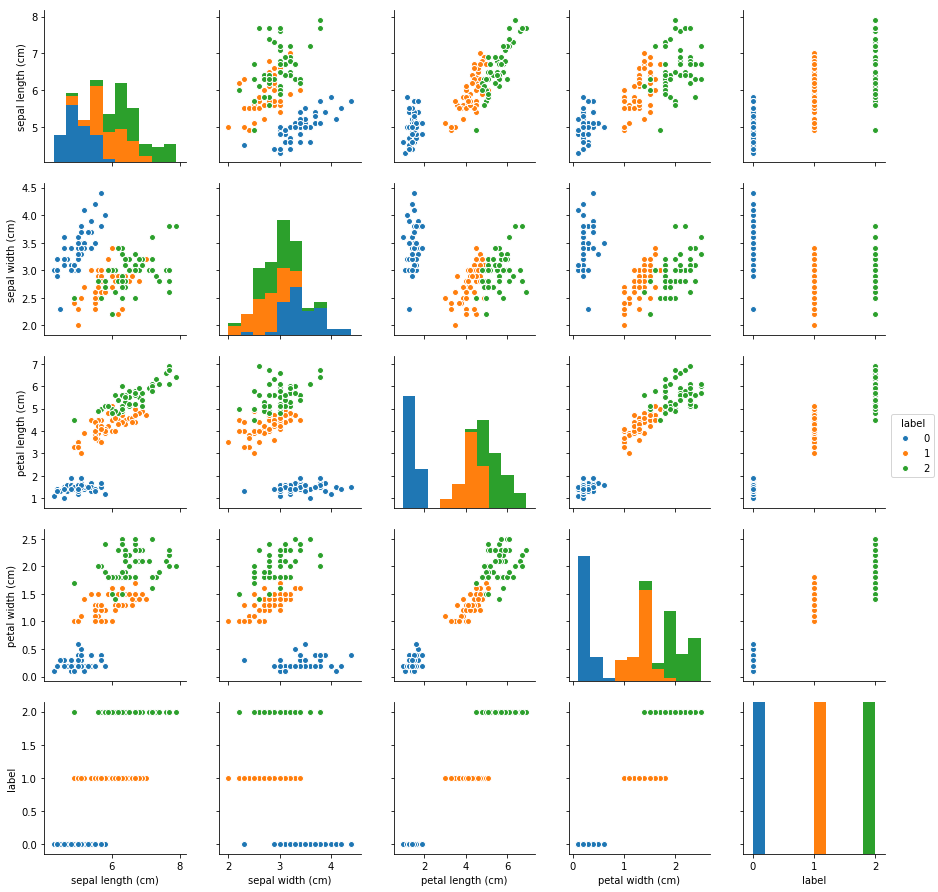

In [108]:
sns.pairplot(iris_df, hue='label')

In [109]:
iris_imb = pd.read_csv('./imbalanced_datasets/imbalanced_iris.csv')
iris_imb.loc[iris_imb['label'] == 0]

,0,1,2,3,label
2,5.2,3.5,1.5,0.2,0
22,5.1,3.7,1.5,0.4,0
42,5.0,3.2,1.2,0.2,0
46,4.8,3.1,1.6,0.2,0
54,5.2,4.1,1.5,0.1,0


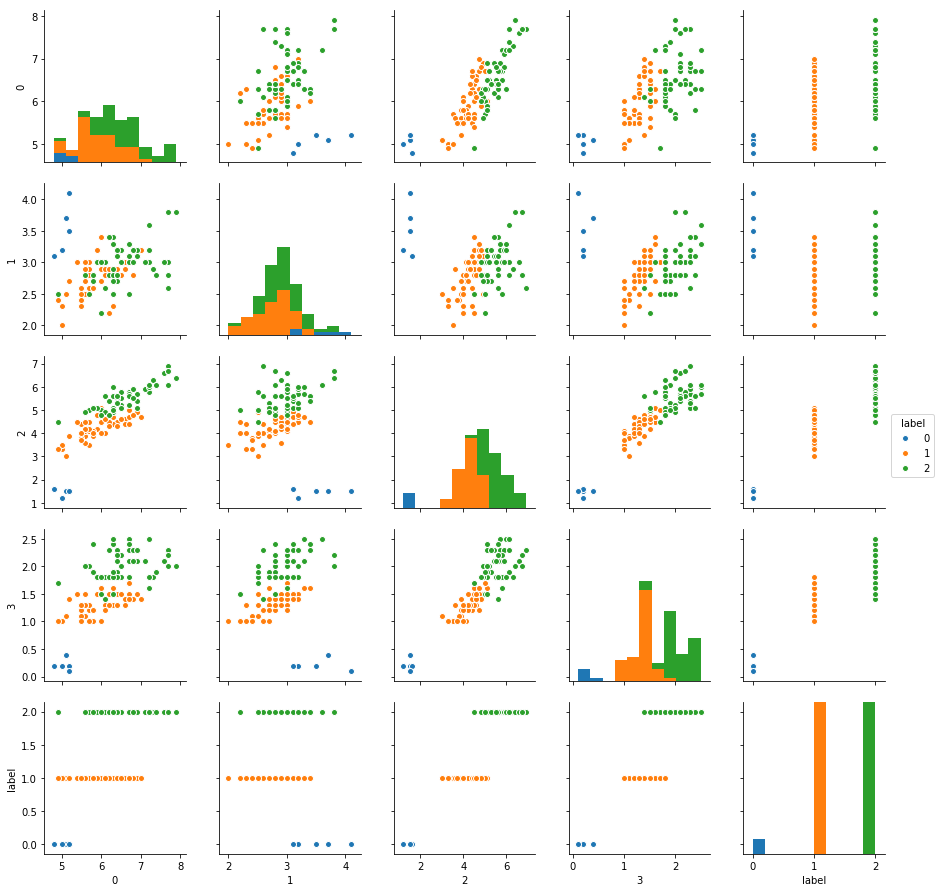

In [110]:
sns.pairplot(iris_imb, hue='label')

In [111]:
iris_smote = smote(iris_imb, 3)

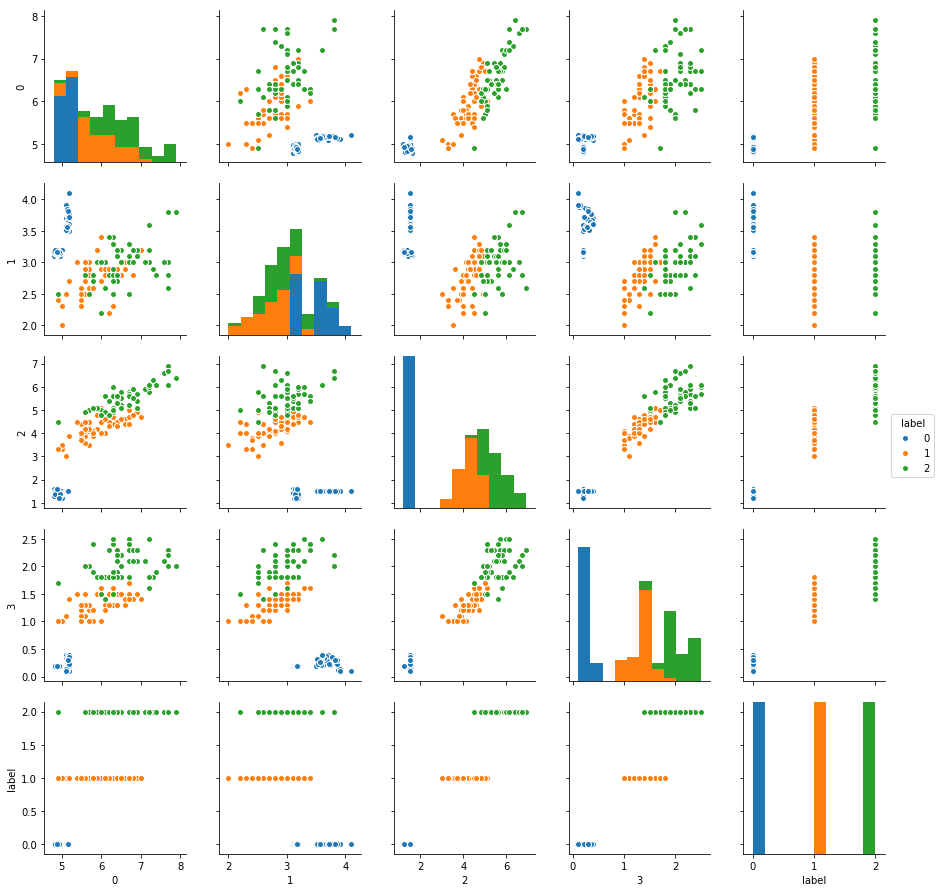

In [112]:
sns.pairplot(iris_smote, hue='label')

In [113]:
import os
try:
    os.mkdir('./smote_datasets')
except:
    pass

In [114]:
iris_smote.to_csv('./smote_datasets/smote_iris.csv')

In [115]:
imb_bc_df = pd.read_csv('./imbalanced_datasets/imbalanced_breast_cancer.csv')

In [116]:
bc_smote = smote(imb_bc_df, 3)
bc_smote.to_csv('./smote_datasets/smote_bc.csv')

In [119]:
imb_wine_df = pd.read_csv('./imbalanced_datasets/imbalanced_wine.csv')

In [120]:
wine_smote = smote(imb_wine_df, 3)
wine_smote.to_csv('./smote_datasets/smote_wine.csv')